## Libs and data

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm
import os

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

In [2]:
# !unzip -p *.zip
# !gzip -d *.gz

In [3]:
!ls

__pycache__                          metric_clf_hft.py
hw2.ipynb                            mid_price_prediction_based_on_ml.pdf


In [4]:
data_dir = "../data/"

def open_parq(file_name):
    file_parq = file_name + ".parquet"
    file_csv = file_name + ".csv"
    if file_parq not in os.listdir(data_dir):
        df = pd.read_csv(data_dir + file_csv)
        df.to_parquet(data_dir + file_parq)
    try:
        df = pd.read_parquet(data_dir + file_parq)
        print(f"read parquet {data_dir + file_csv}")
    except Exception as err: 
        # some parquets are too big? not sure of problem
        print(f"!Problem {type(err)} \n{err}")
        df = pd.read_csv(data_dir + file_csv)
        print(f"read csv {data_dir + file_csv}")
    return df
        
target = open_parq("target")
ticker = open_parq("ticker")
ticker_spot = open_parq("ticker.spot")
trades = open_parq("trades")
trades_spot = open_parq("trades.spot")
book = open_parq("book")
book_spot = open_parq("book.spot")

read parquet ../data/target.csv
!Problem <class 'OSError'> 
Could not open Parquet input source '<Buffer>': Couldn't deserialize thrift: TProtocolException: Invalid data

read csv ../data/ticker.csv
read parquet ../data/ticker.spot.csv
read parquet ../data/trades.csv
read parquet ../data/trades.spot.csv
read parquet ../data/book.csv
read parquet ../data/book.spot.csv


In [5]:
df = target.copy()
# skip first n cause target starts before some of other data
skip_n = 3000
# drop first n cause not enough data for diff features
target_start = df[skip_n:].local_ts.min()
assert book.timestamp.min() < target_start
assert book_spot.timestamp.min() < target_start
assert trades.local_ts.min() < target_start
assert trades_spot.local_ts.min() < target_start
assert ticker.local_ts.min() < target_start
assert ticker_spot.local_ts.min() < target_start
df = df[skip_n:].reset_index(drop = True)
df = df.drop_duplicates(subset = ["local_ts"], keep = "last")
target.shape[0], df.shape[0]

(37565580, 37553681)

## Features from hw1

In [6]:
delay = (trades.local_ts - trades.remote_ts * 1e6) / 1e9
print(f"delay\nmean: {round(delay.mean(), 4)}s\nmax: {round(delay.max(), 4)}s\nmin: {round(delay.min(), 4)}s") 
# delay stats

delay
mean: 0.0884s
max: 5.0143s
min: 0.0017s


In [7]:
def get_l_r(df, trades, time_window = 5000, time_shift = 0, output = False):
    # default window 5s, no time shift
    time_window *= 1000000
    time_shift *= 1000000
    
    # get only from needed time window
    trades_remote_ts = trades.remote_ts * 1000000 + time_shift
    l = np.searchsorted(trades_remote_ts + time_window, df.local_ts)
    l = np.maximum(l - 1, 0) # not including left 
    
    # no future picking
    trades_local_ts = trades.local_ts + time_shift
    r = np.searchsorted(trades_local_ts, df.local_ts)
    r = np.maximum(r - 1, 0) # including right
    
    mask = r - l <= 0
    if output:
        print(f"target with no trades {mask.sum()} {mask.sum()/df.shape[0]}")
    l[mask] = np.maximum(r[mask] - 1, 0)
    return l, r

(bid[0].volume - ask[0].volume)/(bid[0].volume + ask[0].volume)

In [8]:
def add_data(df, data, cols_to_keep, timestamp = "remote_ts", prefix = "_"):
    data = data[cols_to_keep].copy().sort_values(by = [timestamp])
    rename_mapper = {row: prefix + row for row in cols_to_keep}
    rename_mapper[timestamp] = "local_ts"
    data = data.rename(columns = rename_mapper)
    return pd.merge_asof(df, data, on = "local_ts", direction = "backward")
# probably better to use machine timestamp then local_timestamp
# maybe problems with how we wont get it in time, but prob fine

In [9]:
timestamp_to_use = "local_timestamp" # "timestamp" # "local_timestamp" 
def orderbook_imb(df, book, method = "diff", level = 0):
    am = f"asks[{level}].amount"
    bd = f"bids[{level}].amount"
    df_book = add_data(df, book, [timestamp_to_use, am, bd]\
         , timestamp = timestamp_to_use, prefix = "book_")
    asks_amount = df_book[f"book_{am}"].to_numpy()
    bids_amount = df_book[f"book_{bd}"].to_numpy()
    if method == "log":
        return np.log(bids_amount/asks_amount)
    return (bids_amount - asks_amount) / (bids_amount + asks_amount)

In [10]:
df["book_future_imabalance"] = orderbook_imb(df, book)
df["book_future_log_imbalance_custom"] = orderbook_imb(df, book, method = "log")

In [11]:
df_book = add_data(df, book_spot, [timestamp_to_use, "asks[0].amount", "bids[0].amount"]\
         , timestamp = timestamp_to_use, prefix = "book_")
asks_amount = df_book["book_asks[0].amount"].to_numpy()
bids_amount = df_book["book_bids[0].amount"].to_numpy()
df["book_spot_imabalance"] = (bids_amount - asks_amount) / (bids_amount + asks_amount)
df["book_spot_log_imbalance_custom"] = np.log(bids_amount/asks_amount)

In [12]:
def trades_period(df, trades, time_window = 2000):
    l, r = get_l_r(df, trades, time_window = time_window, time_shift = 0)  
    cumsum = np.cumsum(trades.amount).to_numpy()
    return cumsum[r] - cumsum[l]

def trades_imb(df, trades, lookback_window = 2000):
    trades_buy = trades_period(df, trades[trades.side == "B"], time_window = lookback_window)
    trades_sell = trades_period(df, trades[trades.side == "S"], time_window = lookback_window)
    return trades_buy - trades_sell

In [13]:
trades_types = {"trades_future": trades, "trades_spot": trades_spot}
for tt_type in trades_types:
    for window_ms in tqdm([100, 250, 500, 1000, 2000], desc = tt_type):
        tt = trades_types[tt_type]
        df[f"{tt_type}_imb_{window_ms}ms"] = trades_imb(df, tt, lookback_window = window_ms)

Text(0.5, 1.0, 'Power of leverage 1000ms')

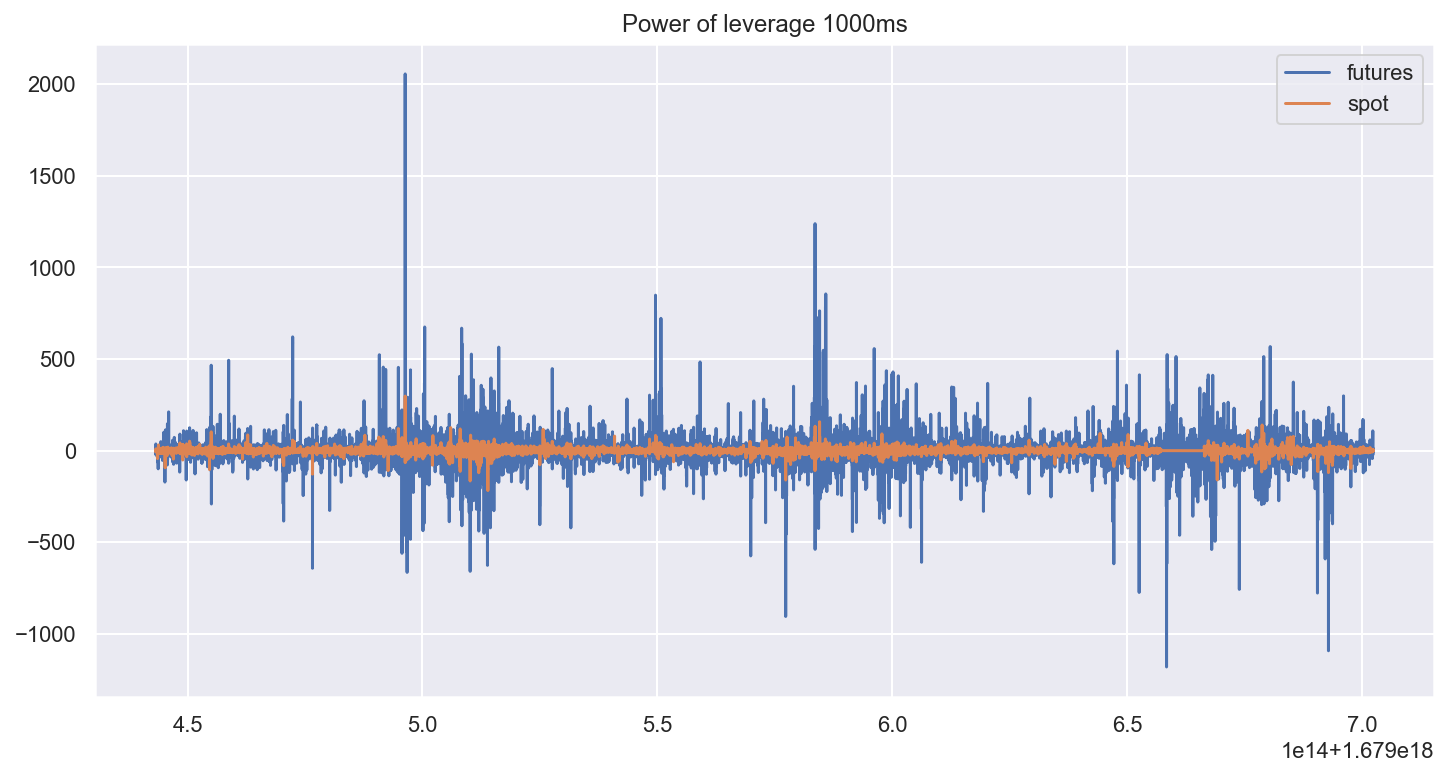

In [14]:
plt.plot(df.local_ts, df.trades_future_imb_1000ms, label = "futures")
plt.plot(df.local_ts, df.trades_spot_imb_1000ms, label = "spot")
plt.legend(loc = 'upper right')
plt.title("Power of leverage 1000ms")

In [15]:
def trades_price_avg_lookback(df, trades, time_horizon = 2000, time_window = 50):
    l, r = get_l_r(df, trades, time_window = time_window, time_shift = time_horizon)
    
    cumsum = np.cumsum(trades.price).to_numpy()
    nums = np.arange(trades.shape[0])

    price_sum = cumsum[r] - cumsum[l]
    price_num = nums[r] - nums[l]
    return price_sum / price_num

def trades_past_returns(df, trades, time_horizon = 2000, time_window = 50):
    price_now = trades_price_avg_lookback(df, trades, time_horizon = 0, time_window = time_window)
    price_past = trades_price_avg_lookback(df, trades, time_horizon = time_horizon, time_window = time_window)
    return (price_now / price_past - 1) * 1000

In [16]:
# ticker_types = {"ticker_future": ticker, "ticker_spot": ticker_spot} 
# used trades as in paper
for tt_type in trades_types:
    for window_ms in tqdm([100, 250, 500, 1000, 2000], desc = tt_type):
        tt = trades_types[tt_type]
        df[f"{tt_type}_past_returns_{window_ms}ms"] = trades_past_returns(df, tt, time_horizon = window_ms)

In [17]:
def price_sets(trades, time_sets, lookback_window = 50 * 1e6):
    trades_remote_ts = trades.remote_ts * 1e6 # from milisec

    l = np.searchsorted(trades_remote_ts + lookback_window, time_sets)
    l = np.maximum(l - 1, 0) # not including left 
    r = np.searchsorted(trades_remote_ts, time_sets)
    
    cumsum = np.cumsum(trades.price).to_numpy()
    nums = np.arange(trades.shape[0])

    price_sum = cumsum[r] - cumsum[l]
    price_num = nums[r] - nums[l]
    return price_sum / price_num

def rolling_mean(df, time_sets, rolling_price, time_horizon = 5000):
    time_horizon *= 1e6 # from milisec

    l = np.searchsorted(time_sets + time_horizon, df.local_ts)
    l = np.maximum(l - 1, 0) # not including left 
    r = np.searchsorted(time_sets, df.local_ts)
    
    cumsum = np.cumsum(rolling_price)
    nums = np.arange(rolling_price.shape[0])

    price_sum = cumsum[r] - cumsum[l]
    price_num = nums[r] - nums[l]
    return price_sum / price_num

In [18]:
def d (price_1, price_2):
    return (price_1 / price_2 - 1) * 10000
def DIV(df, trades_market_1, trades_market_2, time_horizon = 5000, lookback_window = 50):
    price_now_1 = trades_price_avg_lookback(df, trades_market_1\
                                            , time_horizon = 0, time_window = lookback_window)
    price_now_2 = trades_price_avg_lookback(df, trades_market_2\
                                            , time_horizon = 0, time_window = lookback_window)
    
    d_now = d(price_now_1, price_now_2)
    
    # price_rolling_1 = trades_price_avg_lookback(df, trades_market_1\
    #                                        , time_horizon = 0, lookback_window = time_horizon)
    # price_rolling_2 = trades_price_avg_lookback(df, trades_market_2\
    #                                        , time_horizon = 0, lookback_window = time_horizon)
    
    # print("prices_now_done")
    
    trades_market_1 = trades
    trades_market_2 = trades_spot
    start = min(trades_market_1.remote_ts.min(), trades_market_2.remote_ts.min()) * 1e6
    end   = max(trades_market_1.remote_ts.max(), trades_market_2.remote_ts.max()) * 1e6
    lookback_window *= 1e6
    time_sets = start + (np.arange(np.floor((end - start) / lookback_window)) + 1) * lookback_window
    
    pair = get_l_r(df, trades, time_window = lookback_window, time_shift = 0)
    trades_sets_1 = price_sets(trades_market_1, time_sets, lookback_window = lookback_window)
    trades_sets_2 = price_sets(trades_market_2, time_sets, lookback_window = lookback_window)
    
    # print("trades_sets_done")
    
    rolling_price = d(trades_sets_1, trades_sets_2)
    d_rolling = rolling_mean(df, time_sets, rolling_price, time_horizon = time_horizon)
    
    return d_now - d_rolling

In [19]:
for window_s in tqdm([5, 10, 20, 40]):
    window_ms = window_s * 1e3
    df[f"trades_div_{round(window_ms)}ms"] = DIV(df, trades, trades_spot, time_horizon = window_ms)

In [20]:
df.head()

,local_ts,target,book_future_imabalance,book_future_log_imbalance_custom,book_spot_imabalance,book_spot_log_imbalance_custom,trades_future_imb_100ms,trades_future_imb_250ms,trades_future_imb_500ms,trades_future_imb_1000ms,trades_future_imb_2000ms,trades_spot_imb_100ms,trades_spot_imb_250ms,trades_spot_imb_500ms,trades_spot_imb_1000ms,trades_spot_imb_2000ms,trades_future_past_returns_100ms,trades_future_past_returns_250ms,trades_future_past_returns_500ms,trades_future_past_returns_1000ms,trades_future_past_returns_2000ms,trades_spot_past_returns_100ms,trades_spot_past_returns_250ms,trades_spot_past_returns_500ms,trades_spot_past_returns_1000ms,trades_spot_past_returns_2000ms,trades_div_5000ms,trades_div_10000ms,trades_div_20000ms,trades_div_40000ms
0,1679443221766332928,0,0.660298,1.586684,-0.209442,-0.425174,-4.85,-4.85,-3.662,-10.763,-10.747,-0.60648,-0.79633,-0.41088,-0.25742,1.08855,-0.000382,-0.000382,-0.001806,-0.025311,-0.025311,-0.034308,-0.033952,-0.029682,-0.038223,0.010179,0.102784,-0.068538,-0.44799,-0.506559
1,1679443221766335488,0,0.660298,1.586684,-0.209442,-0.425174,-4.85,-4.85,-3.662,-10.763,-10.747,-0.60648,-0.79633,-0.41088,-0.25742,1.08855,-0.000382,-0.000382,-0.001806,-0.025311,-0.025311,-0.034308,-0.033952,-0.029682,-0.038223,0.010179,0.102784,-0.068538,-0.44799,-0.506559
2,1679443221767213056,0,0.660298,1.586684,-0.209442,-0.425174,-4.85,-4.85,-3.662,-10.763,-10.747,-0.60648,-0.79633,-0.41088,-0.25742,1.08855,-0.000382,-0.000382,-0.001173,-0.025311,-0.025311,-0.034308,-0.033952,-0.029682,-0.038223,0.010179,0.102784,-0.068538,-0.44799,-0.506559
3,1679443221769038336,0,-0.950136,-3.666350,-0.209442,-0.425174,-4.85,-4.85,-3.662,-10.763,-10.747,-0.60648,-0.79633,-0.41088,-0.25699,1.08855,-0.000382,-0.000382,-0.001173,-0.025311,-0.025311,-0.034308,-0.033952,-0.029682,-0.038223,0.082435,0.102784,-0.068538,-0.44799,-0.506559
4,1679443221769302784,0,-0.950136,-3.666350,-0.209442,-0.425174,-4.85,-4.85,-3.662,-10.763,-10.747,-0.60648,-0.79633,-0.41088,-0.25699,1.08855,-0.000382,-0.000382,-0.001173,-0.025311,-0.025311,-0.034308,-0.033952,-0.029682,-0.038223,0.082435,0.102784,-0.068538,-0.44799,-0.506559


## Features from hw2

In [21]:
"""
# решение если хотим по времени. Можно сделать эффективнее, но мое железо потянет только так
def get_metrics_price(df, trades):
    l, r = get_l_r(df, trades) 
    metrics = []
    # надо пройтись по элементам, чтобы найти max/min никак быстрее не сделать(((
    for i in tqdm(range(df.shape[0])):
        price_range = trades.price[l[i]:r[i]].to_numpy()
        mmax = np.max(price_range)
        mmin = np.min(price_range)
        clos = price_range[-1]
        metrics.append((mmax, mmin, clos))
    return np.array(metrics)
# но если обращаться с каждым таргетом, как со своим блоком - то больно 
# (хотя было бы железо, делал бы так мб)
"""

'\n# решение если хотим по времени. Можно сделать эффективнее, но мое железо потянет только так\ndef get_metrics_price(df, trades):\n    l, r = get_l_r(df, trades) \n    metrics = []\n    # надо пройтись по элементам, чтобы найти max/min никак быстрее не сделать(((\n    for i in tqdm(range(df.shape[0])):\n        price_range = trades.price[l[i]:r[i]].to_numpy()\n        mmax = np.max(price_range)\n        mmin = np.min(price_range)\n        clos = price_range[-1]\n        metrics.append((mmax, mmin, clos))\n    return np.array(metrics)\n# но если обращаться с каждым таргетом, как со своим блоком - то больно \n# (хотя было бы железо, делал бы так мб)\n'

In [22]:
def block_indexes(tr, block_size = 10):
    tr = tr[:-(tr.shape[0] % block_size)]
    tr_blocked = [tr[i::block_size][:, np.newaxis] for i in range(block_size)]
    return np.concatenate(tr_blocked, axis = 1)

In [23]:
def get_l_r_blocks(df, trades, trds_blocks, time_window = 500, time_shift = 0):
    # default window 5s, no time shift
    time_window *= 1000000 # 1e6
    
    # get only from needed time window
    trades_remote_ts = trades.remote_ts.to_numpy()[trds_blocks][:, 0] * 1000000 + time_shift
    l = np.searchsorted(trades_remote_ts + time_window, df.local_ts)
    
    # no future picking
    trades_local_ts = trades.local_ts.to_numpy()[trds_blocks][:, -1] + time_shift
    r = np.searchsorted(trades_local_ts, df.local_ts)
    r = np.maximum(r - 1, 0)
    
    mask = r - l <= 0
    if mask.sum():
        print(f"l and r within the same block {mask.sum()} "
              f"{round(mask.sum()/df.shape[0], 2)}") # cause to small time widndow for block size
        l[mask] = np.maximum(r[mask] - 1, 0)
    return l, r

In [24]:
def get_blocks_pair(df, trades, block_size = 10):
    trds_blocks = block_indexes(trades.index.to_numpy(), block_size = block_size)
    trds_blocks = np.concatenate([np.zeros((1, block_size)).astype(trds_blocks.dtype), trds_blocks], axis = 0)
    pair_blocks = get_l_r_blocks(df, trades, trds_blocks)
    return trds_blocks, pair_blocks
def get_pair_last(pair):
    return (np.maximum(pair[1] - 1, 0), pair[1]) # последний блок только ... 

In [25]:
# to potimize can hash this function / or just pass n_prev blocks (but better hash if we have memory to spare)
def prev_n_blocks_close(trades, trds_blocks, n_prev, output = False):
    prev_blocks_all = []
    
    rr = range(n_prev)
    if output:
        rr = tqdm(rr, desc = "n_prev")
    for i in rr:
        prev_blocks = trds_blocks - i
        if np.any(prev_blocks) < 0:
            raise ValueError("")  
        price_blocks_prev = trades.price.to_numpy()[prev_blocks[:, -1]]
        block_last_prev = price_blocks_prev[:, np.newaxis]
        
        prev_blocks_all.append(block_last_prev)
        
    return np.concatenate(prev_blocks_all, axis = 1)

In [26]:
def avg_metric(metric, pair_blocks):
    l, r = pair_blocks
    cumsum = np.cumsum(metric, axis = 0)
    nums = np.arange(trds_blocks.shape[0])
    
    metrics_sum = cumsum[r] - cumsum[l]
    metrics_num = nums[r] - nums[l]
    
    if metrics_sum.ndim >= 2:
        metrics_num = metrics_num.reshape(-1, 1)
    
    return metrics_sum / metrics_num
def lin_weighted_metric(metric, pair_blocks):
    weights = np.linspace(0, 1, num = metric.shape[1])
    weighted_metric = (metric * weights).sum(axis = 1) / weights.sum()
    return avg_metric(weighted_metric, pair_blocks)

In [27]:
def remove_zero_div(metric):
    param = metric.copy()
    mask = param == 0
    param[mask] = param[~mask].min() * 1e-9
    return param

def rolling_window(FF, n_prev, f = lambda x: x.sum()):
    FF_ = [FF[0] for i in range(n_prev - 1)]
    FF_ = np.concatenate([FF_, FF])
    AFF = pd.Series(FF_).rolling(n_prev)
    return f(AFF).to_numpy()[(n_prev - 1):]
def average_row(FF, n_prev, token = ""):
    AFF = [FF[0]]
    rr = range(1, FF.shape[0])
    if token:
        rr = tqdm(rr, desc = "averaging " + token)
    for i in rr:
        AFF.append((np.sum(AFF[-(n_prev - 1):]) + FF[i]) / n_prev)
    return np.array(AFF)

In [28]:
trds_blocks, pair_blocks = get_blocks_pair(df, trades, 10)
pair_blocks_last = get_pair_last(pair_blocks)

l and r within the same block 12606975 0.34


#### features def and calc:

In [29]:
def get_metrics_price(trades, trds_blocks, pair_blocks):
    price_blocks = trades.price.to_numpy()[trds_blocks]
    
    block_max = np.max(price_blocks, axis = 1)[:, np.newaxis]
    block_min = np.min(price_blocks, axis = 1)[:, np.newaxis]
    block_last = price_blocks[:, -1][:, np.newaxis]
    
    metric_price = np.concatenate([block_max, block_min, block_last], axis = 1)
    
    return metric_price
def get_metrics_volume(trades, trds_blocks, pair_blocks):
    volume_blocks = trades.amount.to_numpy()[trds_blocks]
    
    metrics_volume = np.sum(volume_blocks, axis = 1)  
    
    return metrics_volume

In [30]:
def get_ADL(trades, trds_blocks, pair_blocks):
    metrics_price = get_metrics_price(trades, trds_blocks, pair_blocks)
    metrics_volume = get_metrics_volume(trades, trds_blocks, pair_blocks)
    
    H = metrics_price[:, 0]
    L = metrics_price[:, 1]
    CL = metrics_price[:, 2]
    
    MoneyFlowMultiplier = ((CL - L) - (H - CL)) / remove_zero_div(H - L)
    
    BlockPeriodVolume = metrics_volume
    MoneyFlowVolume = MoneyFlowMultiplier * BlockPeriodVolume
    ADL = rolling_window(MoneyFlowVolume, 1)
    return avg_metric(ADL, pair_blocks)

In [31]:
df["ADL"] = get_ADL(trades, trds_blocks, pair_blocks_last)

In [32]:
def prev(FF):
    return np.concatenate([[FF[0]], FF[:-1]])
def smoothing_Wilder(FF, n_prev):
    FF_sum = rolling_window(FF, n_prev)
    FF_prev = prev(FF_sum)
    return FF_prev - FF_prev / n_prev + FF

In [33]:
def get_DI(DM, ATR, mask, n_prev):
    DM_H = np.zeros(mask.shape[0])
    DM_H[mask] = DM[mask]
    
    DM_smoothed = smoothing_Wilder(DM_H, n_prev)
    DM_smoothed[~mask] = 0
    
    return DM_smoothed / remove_zero_div(ATR) * 100

def get_ADX(trades, trds_blocks, pair_blocks, n_prev = 14, output = False):
    price_blocks = trades.price.to_numpy()[trds_blocks]
    
    H = np.max(price_blocks, axis = 1)
    L = np.min(price_blocks, axis = 1)
    CL = price_blocks[:, -1]
    CL_prev = np.concatenate([[CL[0]], CL[:-1]])

    # abs not rly needed but why not ?)
    TR = np.maximum(np.abs(H - L), np.maximum(np.abs(H - CL_prev), np.abs(L - CL_prev)))
    # ATR = average_row(TR, n_prev, "TR" * output)
    # ATR = rolling_window(TR, n_prev, f = lambda x: x.sum() / n_prev)
    ATR = smoothing_Wilder(TR, n_prev)
    
    DM_plus = H - prev(H)
    DM_minus = prev(L) - L

    DI_plus = get_DI(DM_plus, ATR, DM_plus > DM_minus, n_prev)
    DI_minus = get_DI(DM_minus, ATR, DM_plus < DM_minus, n_prev)
    
    DX = np.abs(DI_plus - DI_minus) / remove_zero_div(np.abs(DI_plus + DI_minus)) * 100
    # ADX = rolling_window(DX, n_prev, f = lambda x: x.sum() / n_prev)
    ADX = average_row(DX, n_prev, "DX" * output)
    # ADX = smoothing_Wilder(DX, n_prev)
    return avg_metric(ADX, pair_blocks)

In [34]:
# Average directional index
df["ADX"] = get_ADX(trades, trds_blocks, pair_blocks_last, output = True)

In [35]:
def get_Chande_Mom_Osc(trades, trds_blocks, pair_blocks, n_prev = 20, output = False):
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, n_prev, output)
    
    indc_list = [np.ones(trds_blocks.shape[0]).astype(bool)[:, np.newaxis]]
    # у них опечатка с индексами t -> i
    for i in range(1, n_prev):
        indc_list.append((prev_blocks[:, i] >= prev_blocks[:, i - 1])[:, np.newaxis])
        
    indc = np.concatenate(indc_list, axis = 1)
    S_u = (prev_blocks * indc).sum(axis = 1)
    S_d = (prev_blocks * ~indc).sum(axis = 1)
        
    oscillator = (S_u - S_d)/(S_u + S_d) * 100
    
    return avg_metric(oscillator, pair_blocks)

In [36]:
df["CMO"] = get_Chande_Mom_Osc(trades, trds_blocks, pair_blocks, output = True)

In [37]:
def get_Rate_Of_Change(trades, trds_blocks, pair_blocks, n_prev = 12, output = False):
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, n_prev, output)
        
    CL_prev = prev_blocks.mean(axis = 1)
    CL = prev_blocks[:, 0]
        
    rate_change = (CL - CL_prev) / CL_prev * 100
    
    return avg_metric(rate_change, pair_blocks)

In [38]:
df["ROC"] = get_Rate_Of_Change(trades, trds_blocks, pair_blocks, output =  True)

In [39]:
def get_Momentum(trades, trds_blocks, pair_blocks, output = False):
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, 2, output)
    momentum = prev_blocks[:, 0] - prev_blocks[:, 1]
    return avg_metric(momentum, pair_blocks)

In [40]:
df["MOM"] = get_Momentum(trades, trds_blocks, pair_blocks, output = True)

In [41]:
def get_RSI(trades, trds_blocks, pair_blocks, n_prev = 14, output = False):
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, n_prev, output)
    
    indc_list = [np.ones(trds_blocks.shape[0]).astype(bool)[:, np.newaxis]]
    # у них опечатка с индексами t -> i
    for i in range(1, n_prev):
        indc_list.append((prev_blocks[:, i] >= prev_blocks[:, i - 1])[:, np.newaxis])
        
    indc = np.concatenate(indc_list, axis = 1)
    S_u = (prev_blocks * indc).sum(axis = 1) # AG * n
    S_d = (prev_blocks * ~indc).sum(axis = 1) # AL * n
    
    Rel_Strength = S_u / remove_zero_div(S_d)
        
    RSI = 100 - 100 / (1 + Rel_Strength)
    
    return avg_metric(RSI, pair_blocks)

In [42]:
# just cause already coded this one in
# df["RSI"] = get_RSI(trades, trds_blocks, pair_blocks, output = True)
# plt.plot(np.sort(df.RSI.to_numpy()))

In [43]:
def get_Stock_RSI(trades, trds_blocks, pair_blocks, n_prev_rsi = 14, n_prev_stock = 10, output = False):
    num = n_prev_rsi + n_prev_stock - 1
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, num, output)
    
    indc_list = [np.ones(trds_blocks.shape[0]).astype(bool)[:, np.newaxis]]
    # у них опечатка с индексами t -> i
    for i in range(1, num):
        indc_list.append((prev_blocks[:, i] >= prev_blocks[:, i - 1])[:, np.newaxis])
        
    indc = np.concatenate(indc_list, axis = 1)
    
    S_u = (prev_blocks * indc).cumsum(axis = 1) 
    S_d = (prev_blocks * ~indc).cumsum(axis = 1) 
    
    RSI_s = []
    
    rr = range(n_prev_stock)
    if output:
        rr = tqdm(rr, desc = "calc stock")
    for i in rr:
        S_u_i = S_u[:, i + (n_prev_rsi - 1)]
        if i > 0:
            S_u_i -= S_u[:, i - 1]
        
            
        S_d_i = S_d[:, i + (n_prev_rsi - 1)]
        if i > 0:
            S_d_i -= S_d[:, i - 1]
            
        Rel_Strength = S_u_i / remove_zero_div(S_d_i)
        RSI_i = 100 - 100 / (1 + Rel_Strength)
        RSI_s.append(RSI_i[:, np.newaxis])
        
    RSI_n = np.concatenate(RSI_s, axis = 1)
    
    RSI_diff = RSI_n.max(axis = 1) - RSI_n.min(axis = 1)
    # print(np.abs((avg_metric(RSI_n[:, 0], pair_blocks) -\
    #    get_RSI(trades, trds_blocks, pair_blocks, n_prev_rsi))).sum()) # 0.0
    Stock_RSI = (RSI_n[:, 0] - RSI_n.min(axis = 1)) / remove_zero_div(RSI_diff)
    return avg_metric(Stock_RSI, pair_blocks)

In [44]:
# Stochastic Relative Strength Index
df["Stock_RSI"] = get_Stock_RSI(trades, trds_blocks, pair_blocks, output = True)
# plt.plot(np.sort(df.Stock_RSI.to_numpy()))

In [45]:
def get_LinReg_coefs(trades, trds_blocks, pair_blocks, output = False):
    # np.linalg.solve # sadly decided to do it by hand
    prices = trades.price.to_numpy()[trds_blocks]
    # ?? last know price within block?
    MB_prices = prices[:, :-1]
    PV = prices[:, 1:] 
    MB_prices_mean = MB_prices.mean(axis = 1).reshape(-1, 1)
    PV_mean = PV.mean(axis = 1).reshape(-1, 1)
    
    diff_sum = ((MB_prices - MB_prices_mean)*(PV - PV_mean)).sum(axis = 1)
    corr_coef = ((MB_prices - MB_prices_mean)**2).sum(axis = 1) * ((PV - PV_mean)**2).sum(axis = 1)
    r = diff_sum / remove_zero_div(corr_coef)
    c2 = (PV.std(axis = 1) / remove_zero_div(MB_prices.std(axis = 1))).reshape(-1, 1)
    c1 = PV_mean - c2 * MB_prices_mean
    
    return avg_metric(c1, pair_blocks), avg_metric(c2, pair_blocks), avg_metric(corr_coef, pair_blocks)

In [46]:
# Linear regression line
df["Reg_inter"], df["Reg_slope"], df["Reg_corr"] = get_LinReg_coefs(trades, trds_blocks, pair_blocks)

In [47]:
def prev_n(FF, n_prev = 2):
    return np.concatenate([FF[0].reshape(1, -1) for i in range(n_prev)] +  [FF[:-n_prev]], axis = 0)

In [48]:
def get_Autocorrelation(trades, trds_blocks, pair_blocks, lag = 2, output = False):
    price_b = trades.price.to_numpy()[trds_blocks]
    mu = price_b.mean(axis = 1).reshape(-1, 1)
    price_b_lag = prev_n(price_b, lag)
    top = np.mean((price_b - mu) * (price_b_lag - mu), axis = 1)
    bot = np.mean((price_b - mu)**2) * np.mean((price_b_lag - mu)**2, axis = 1)
    ac = top / remove_zero_div(np.sqrt(bot))
    return avg_metric(ac, pair_blocks)

In [49]:
# Quant Analysis 8 Autocorrelation
df["AC"] = get_Autocorrelation(trades, trds_blocks, pair_blocks, output = True)

In [118]:
def get_Partial_Correlation(trades, trds_blocks, pair_blocks, output = True):
    # dummy TODO
    return get_Autocorrelation(trades, trds_blocks, pair_blocks, output = True)  + np.random.rand(df.shape[0])

In [119]:
# Quant Analysis 9 Partial Correlation
df["PC"] = get_Partial_Correlation(trades, trds_blocks, pair_blocks, output = True)

In [51]:
def prep_window(df, data, cols_to_keep, timestamp = "local_timestamp", prefix = "", time_window = 2000):
    rename_mapper = {row: prefix + row for row in cols_to_keep}
    rename_mapper[timestamp] = "local_ts"
    
    data = data[cols_to_keep].copy().sort_values(by = [timestamp])
    data = data.rename(columns = rename_mapper)
    data.local_ts = pd.to_datetime(data.local_ts)
    return data

In [52]:
def get_Cointegration(df, book, level = 0, time_window = 2000):
    am = f"asks[{level}].amount"
    bd = f"bids[{level}].amount"
    prefix = "book_"
    data = prep_window(df, book, [timestamp_to_use, am, bd]\
         , timestamp = timestamp_to_use, prefix = prefix, time_window = time_window)
    rwindow = data.rolling(f"{time_window}ms", on = "local_ts")
    am = prefix + am
    bd = prefix + bd
    def calc(ser):
        ss = data.loc[ser.index]
        A = ss[am]
        B = ss[bd]
        alpha = (A / B).mean()
        return (A - alpha * B).mean()
    # no other way?(
    coin = rwindow.apply(calc, raw=False)
    return coin

In [53]:
# Quant Analysis 10 Cointegration based on Engle-Granger test
# df["COIN"] = get_Cointegration(df, book_spot) 
# very very slow 
# don't see a way to optimise 
# if you wait out seems ok

In [64]:
def get_Cointegration_fast(df, book, level = 0, time_window = 2000):
    am = f"asks[{level}].amount"
    bd = f"bids[{level}].amount"
    prefix = "book_"
    data = add_data(df, book, [timestamp_to_use, am, bd]\
         , timestamp = timestamp_to_use, prefix = prefix)
    asks_amount = df_book[f"{prefix}{am}"].to_numpy()
    bids_amount = df_book[f"{prefix}{bd}"].to_numpy()
    # very bad estimator # change later tho)
    alpha = (bids_amount / bids_amount).mean() 
    return (asks_amount - alpha * bids_amount)

In [65]:
# faster but worse var cause 
df["COIN"] = get_Cointegration_fast(df, book_spot)

In [55]:
# Quant Analysis 11 Order Book Imbalance
for i in tqdm(range(4)):
    df[f"VI_{i}"] = orderbook_imb(df, book_spot, level = i, method = "diff")

In [120]:
def get_Adaptive_Logistic_Regression(trades, trds_blocks, pair_blocks, output = True):
    # dummy TODO
    return avg_metric(np.random.rand(trds_blocks.shape[0]), pair_blocks)

In [123]:
# Quant Analysis 12 Adaptive Logistic Regression
df["ALogReg"] = get_Adaptive_Logistic_Regression(trades, trds_blocks, pair_blocks, output = True)

In [57]:
def get_Realized_Var(trades, trds_blocks, pair_blocks, n_prev = 20, output = False):
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, n_prev, output)
    # 1st block doesn't matter cause no target chooses that one
    ones_block = np.ones((1, prev_blocks.shape[1]))
    prev_prev_blocks = np.concatenate([ones_block, prev_blocks[:-1, :]], axis = 0)
    r = np.log(prev_blocks) - np.log(prev_prev_blocks)
    RVar = (r ** 2).sum(axis = 1) / n_prev * 100
    RVar = np.concatenate([[0], RVar])
    return avg_metric(RVar, pair_blocks)
            
def get_Realized_Vol(trades, trds_blocks, pair_blocks, n_prev = 20, output = False):
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, n_prev, output)
    ones_block = np.ones((1, prev_blocks.shape[1]))
    prev_prev_blocks = np.concatenate([ones_block, prev_blocks[:-1, :]], axis = 0)
    r = np.log(prev_blocks) - np.log(prev_prev_blocks)
    RVar = (r ** 2).sum(axis = 1) / n_prev * 100
    RVol = np.sqrt(RVar) * 100
    return avg_metric(RVol, pair_blocks)

In [58]:
# Realized Variance (cause why not)
# df["RVar"] = get_Realized_Var(trades, trds_blocks, pair_blocks, output = True)

In [59]:
# Realized Volatility
df["RVol"] = get_Realized_Vol(trades, trds_blocks, pair_blocks, output = True)

In [60]:
def y(X): # not sure
    return ((X - X.mean())**2).mean(axis = 1)
def get_Realized_Kernel(trades, trds_blocks, pair_blocks, n_prev = 10, output = False):
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, n_prev, output)
    zeros_block = np.zeros((1, prev_blocks.shape[1]))
    r = y(prev_blocks)
    kernel = [r[:, np.newaxis]]
    rr = range(1, n_prev)
    if output:
        rr = tqdm(rr, desc = "cal kernel")
    for i in rr:
        h_H = i / n_prev
        k = (1 + h_H) * np.exp(-h_H)
        prev_i_blocks = np.concatenate([zeros_block for i in range(i)] + [prev_blocks[:-i, :]], axis = 0)
        r = (y(prev_blocks) + y(prev_i_blocks)) / 2 # idk just feels better this way
        kernel.append((k * r)[:, np.newaxis])
    RK = np.concatenate(kernel).sum(axis = 1) / n_prev * 100
    return avg_metric(RK, pair_blocks)

In [61]:
# Realized Kernel
df["RK"] = get_Realized_Kernel(trades, trds_blocks, pair_blocks, output = True)

In [62]:
def get_Jump_Variation(trades, trds_blocks, pair_blocks, n_prev = 10, n_lag = 2, output = False):
    prev_blocks = prev_n_blocks_close(trades, trds_blocks, n_prev + n_lag, output)
    ones_block = np.ones((1, prev_blocks.shape[1]))
    prev_prev_blocks = np.concatenate([ones_block, prev_blocks[:-1, :]], axis = 0)
    r = np.log(prev_blocks) - np.log(prev_prev_blocks)
    RVar = (r[:, :n_prev] ** 2).sum(axis = 1)
    RBiVar_s = np.abs(r[:, :-n_lag]) * np.abs(r[:, n_lag:])
    RBiVar = np.pi / 2 * RBiVar_s.sum(axis = 1)
    
    JumVar = np.maximum(RVar - RBiVar, 0) / n_prev * 100
    return avg_metric(JumVar, pair_blocks)

In [63]:
# Jump Variation
df["JumpVar"] = get_Jump_Variation(trades, trds_blocks, pair_blocks)

## Some Feture Analysis 

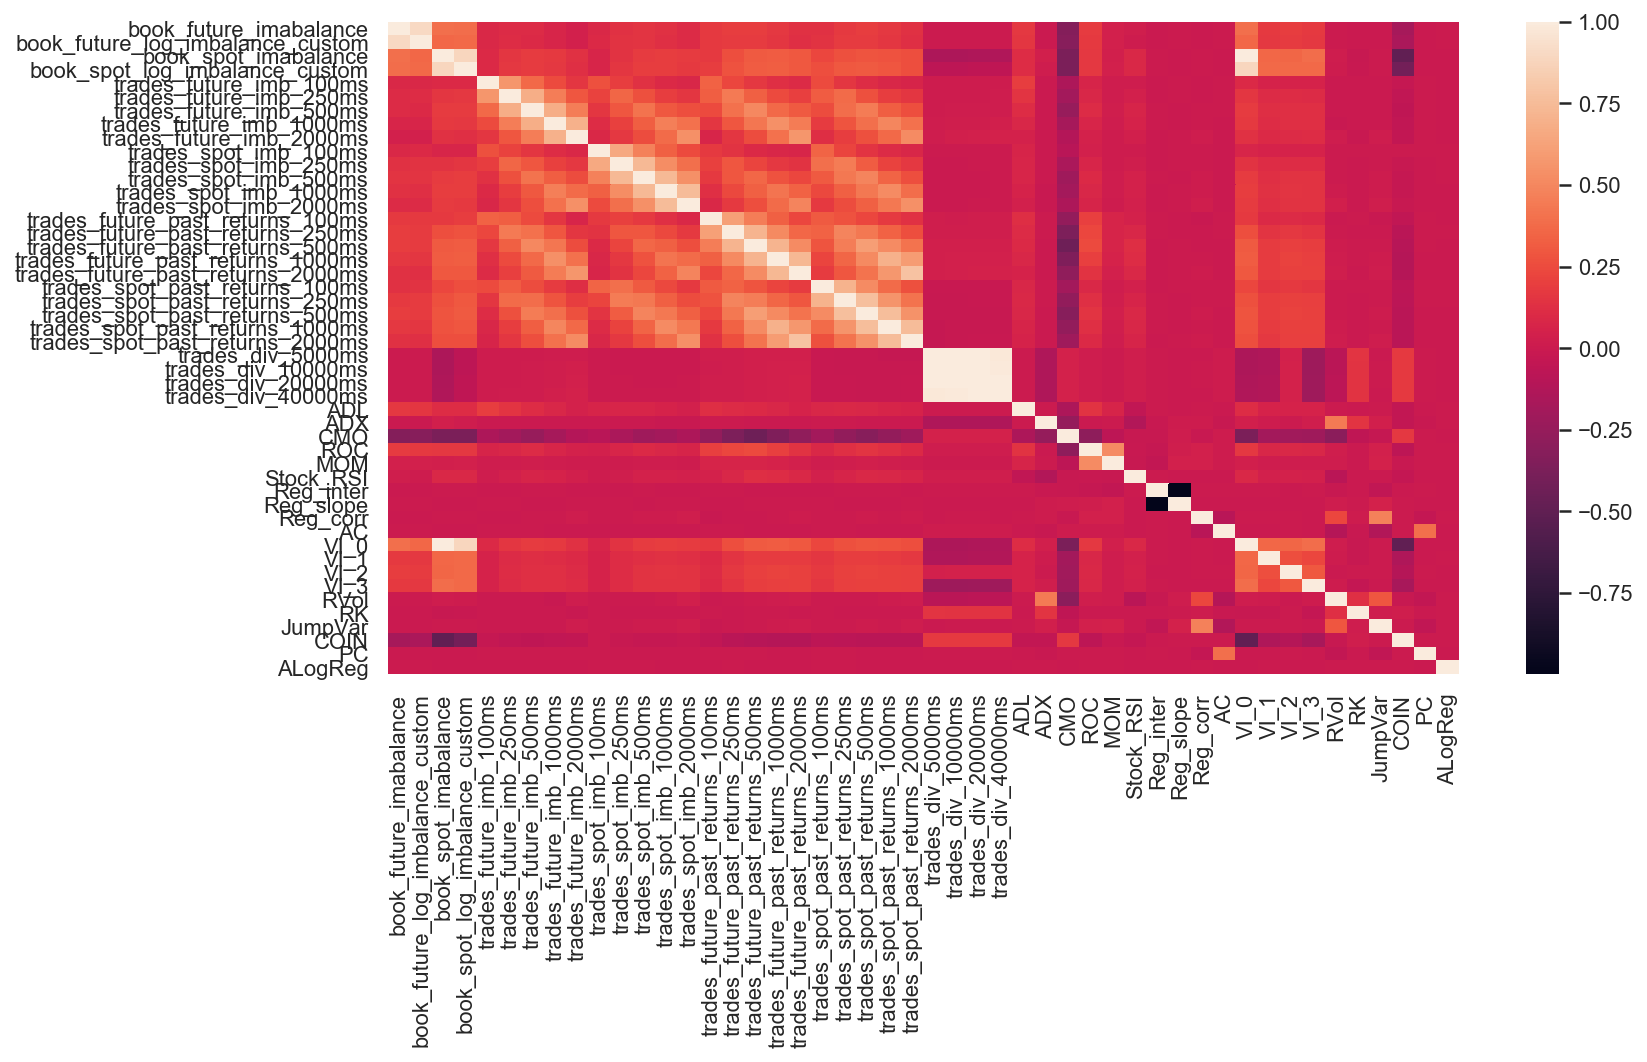

In [124]:
corr = df[::10].drop(columns = ["local_ts", "target"]).corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Model

In [69]:
df.describe()

,local_ts,target,book_future_imabalance,book_future_log_imbalance_custom,book_spot_imabalance,book_spot_log_imbalance_custom,trades_future_imb_100ms,trades_future_imb_250ms,trades_future_imb_500ms,trades_future_imb_1000ms,trades_future_imb_2000ms,trades_spot_imb_100ms,trades_spot_imb_250ms,trades_spot_imb_500ms,trades_spot_imb_1000ms,trades_spot_imb_2000ms,trades_future_past_returns_100ms,trades_future_past_returns_250ms,trades_future_past_returns_500ms,trades_future_past_returns_1000ms,trades_future_past_returns_2000ms,trades_spot_past_returns_100ms,trades_spot_past_returns_250ms,trades_spot_past_returns_500ms,trades_spot_past_returns_1000ms,trades_spot_past_returns_2000ms,trades_div_5000ms,trades_div_10000ms,trades_div_20000ms,trades_div_40000ms,ADL,ADX,CMO,ROC,MOM,Stock_RSI,Reg_inter,Reg_slope,Reg_corr,AC,VI_0,VI_1,VI_2,VI_3,RVol,RK,JumpVar,COIN
count,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07,3.755368e+07
mean,1.679562e+18,2.610663e-03,2.716714e-03,1.880403e-02,3.818722e-02,1.072694e-01,-2.286819e-02,-7.016790e-02,-1.306809e-01,-2.060578e-01,-2.074841e-01,-5.558330e-03,-1.458217e-02,-2.911595e-02,-4.406759e-02,-6.593523e-02,-1.838783e-04,-4.179174e-04,-5.253138e-04,-3.295184e-04,-2.566494e-04,-1.134901e-04,-2.199146e-04,-3.419619e-04,-4.035606e-04,-5.176196e-04,-2.011088e+00,-2.008773e+00,-2.008444e+00,-2.006358e+00,5.134963e-03,6.846438e+01,7.285265e+01,6.641077e-06,7.666861e-04,5.553852e-01,-1.572970e+12,5.641323e+07,1.541350e+03,1.870546e-03,3.818722e-02,2.668116e-02,-1.367323e-02,4.009062e-02,1.591282e-02,2.062017e+06,6.630149e-09,-7.492540e-01
std,7.237115e+13,7.207821e-01,6.857115e-01,3.100855e+00,6.615503e-01,2.978506e+00,6.335476e+00,1.220992e+01,1.884377e+01,2.931195e+01,5.028033e+01,1.449653e+00,2.477893e+00,3.643813e+00,5.379350e+00,7.938325e+00,7.196135e-02,1.074363e-01,1.459766e-01,2.017453e-01,2.880602e-01,4.568206e-02,7.925824e-02,1.188734e-01,1.755100e-01,2.582945e-01,1.058111e+01,1.062073e+01,1.069363e+01,1.081199e+01,1.643631e+00,1.283070e+01,2.347191e+01,1.691498e-03,3.757105e-01,3.488385e-01,2.161633e+13,7.653039e+08,1.853799e+05,1.261429e-01,6.615503e-01,7.703064e-01,7.724118e-01,8.098278e-01,2.810846e-02,2.227351e+06,2.658549e-07,1.096456e+01
min,1.679443e+18,-1.000000e+00,-9.999960e-01,-1.311028e+01,-9.999993e-01,-1.481290e+01,-5.661680e+02,-1.025715e+03,-1.065844e+03,-1.181167e+03,-1.515234e+03,-1.099867e+02,-2.067753e+02,-2.084266e+02,-2.178813e+02,-3.142373e+02,-5.217856e+00,-5.975000e+00,-4.407144e+00,-4.500000e+00,-5.950248e+00,-5.698006e+00,-5.698006e+00,-5.765453e+00,-5.975783e+00,-6.004274e+00,-9.677720e+01,-1.086315e+02,-1.343577e+02,-1.569627e+02,-2.810640e+02,1.785330e+01,-8.999926e+01,-2.561734e-01,-9.340000e+01,0.000000e+00,-1.516181e+16,0.000000e+00,0.000000e+00,-2.331266e+01,-9.999993e-01,-9.999932e-01,-9.999915e-01,-9.999889e-01,0.000000e+00,1.464844e-03,0.000000e+00,-5.937426e+02
25%,1.679505e+18,-1.000000e+00,-6.504422e-01,-1.552129e+00,-5.755311e-01,-1.311509e+00,-3.550000e-01,-1.079000e+00,-2.103000e+00,-3.639000e+00,-6.081000e+00,-4.051000e-02,-1.109600e-01,-2.706900e-01,-6.499700e-01,-1.362540e+00,-3.576675e-03,-7.101982e-03,-2.333483e-02,-4.711753e-02,-7.777976e-02,0.000000e+00,-3.519622e-04,-3.571699e-04,-3.666763e-04,-2.134746e-02,-3.950325e-01,-4.660215e-01,-5.263969e-01,-5.765489e-01,-4.670000e-01,5.951803e+01,6.000006e+01,-2.896143e-04,-1.764706e-02,3.333333e-01,-1.536000e+03,6.822917e-01,2.422333e-04,-1.984021e-04,

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from metric_clf_hft import metric
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [71]:
df_cut = df.drop(columns = ["local_ts"])
X_ = df_cut.drop(columns = ["target"])
y_ = df_cut.target.to_numpy()

In [73]:
# not using, but still here
def bad_idea():
    ct = ColumnTransformer([
            ('scaler', StandardScaler(), X_.columns)
        ], remainder='drop')
    return ct.fit_transform(X_)
# X_scaled_all = bad_idea()

0.7 train - 0.1 val - 0.2 test

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

In [85]:
X_train.shape, X_val.shape, X_test.shape

((26287576, 46), (3755368, 46), (7510737, 46))

#### Small test on linear model

In [75]:
model = LinearRegression() # maybe try classification next
model.fit(X_train, y_train)

LinearRegression()

In [76]:
y_pred = model.predict(X_test)

In [127]:
def calc_metric(y_test, y_pred, th = 0.5, output = False):
    ans = np.zeros(y_pred.shape[0])
    ans[y_pred > th] = 1
    ans[y_pred < -th] = -1
    if output:
        unique, counts = np.unique(ans, return_counts=True)
        print(dict(zip(unique,counts)))
    return metric(y_test, ans)
calc_metric(y_test, y_pred, th = 1e-06, output = True)

{-1.0: 3696201, 0.0: 45, 1.0: 3814491}


793.6039472636969

In [110]:
# metric doesn't punish enough for spamming answers 
# or maybe reality doesn't (with low fees)
# + i not doing backtesting
def find_thr(layers, test_perc = 0.1, output = True, mode = "linreg"):
    metrics = []
    if output:
        layers = tqdm(layers)
    for th in layers:
        n = y_pred.shape[0]
        mask = np.random.choice(np.arange(n), size=round(n * test_perc), replace=False)
        if mode == "linreg":
            ans = np.zeros(mask.shape[0])
            ans[y_pred[mask] > th] = 1
            ans[y_pred[mask] < -th] = -1
        elif mode == "logreg":
            ans = y_pred[mask]
        else:
            raise ValueError()
        mm = calc_metric(y_test[mask], ans, th = th)
        metrics.append((mm, th))
        if output:
            print(th, mm)
    return max(metrics)
find_thr([1e-6, 0.001, 0.05, 0.1, 0.25, 0.5, 0.75], output = False)

(251.125213191917, 1e-06)

Самые важные для лин модели фичи (часть фичей не нормализирована, так что инсайды so so)

In [87]:
top_n = 10
mean_cols = X_train.mean().to_numpy()
std_cols = X_train.std().to_numpy()
abs_coefs = np.abs(model.coef_ * mean_cols / std_cols)
t_idx = np.argsort(-abs_coefs)[:top_n]
weights = abs_coefs[t_idx]
t_cols = X_.columns[t_idx]
for i in range(top_n):
    print(f"{t_cols[i]} {round(weights[i], 3)}")

RVol 0.003
trades_div_5000ms 0.003
trades_div_20000ms 0.002
VI_0 0.001
book_spot_imabalance 0.001
CMO 0.001
trades_future_past_returns_250ms 0.0
book_future_imabalance 0.0
book_spot_log_imbalance_custom 0.0
trades_future_past_returns_100ms 0.0


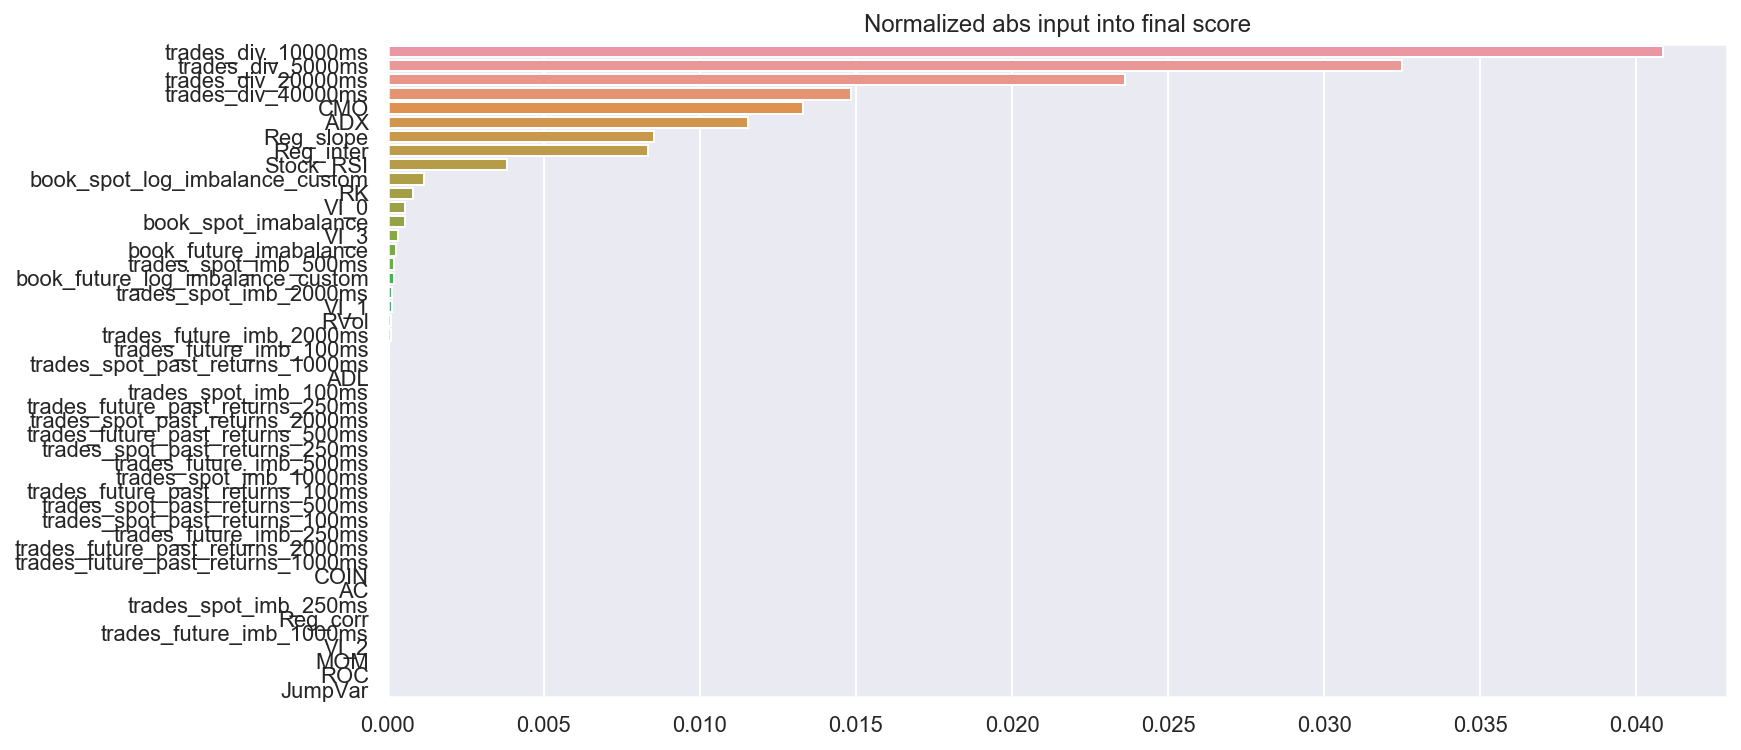

In [99]:
model_gain = model.coef_ * X_train.mean() 
model_gain = model_gain.abs().sort_values(ascending = False)
plt.title("Normalized abs input into final score")
sns.barplot(x = model_gain.values, y = model_gain.index, orient = "h")

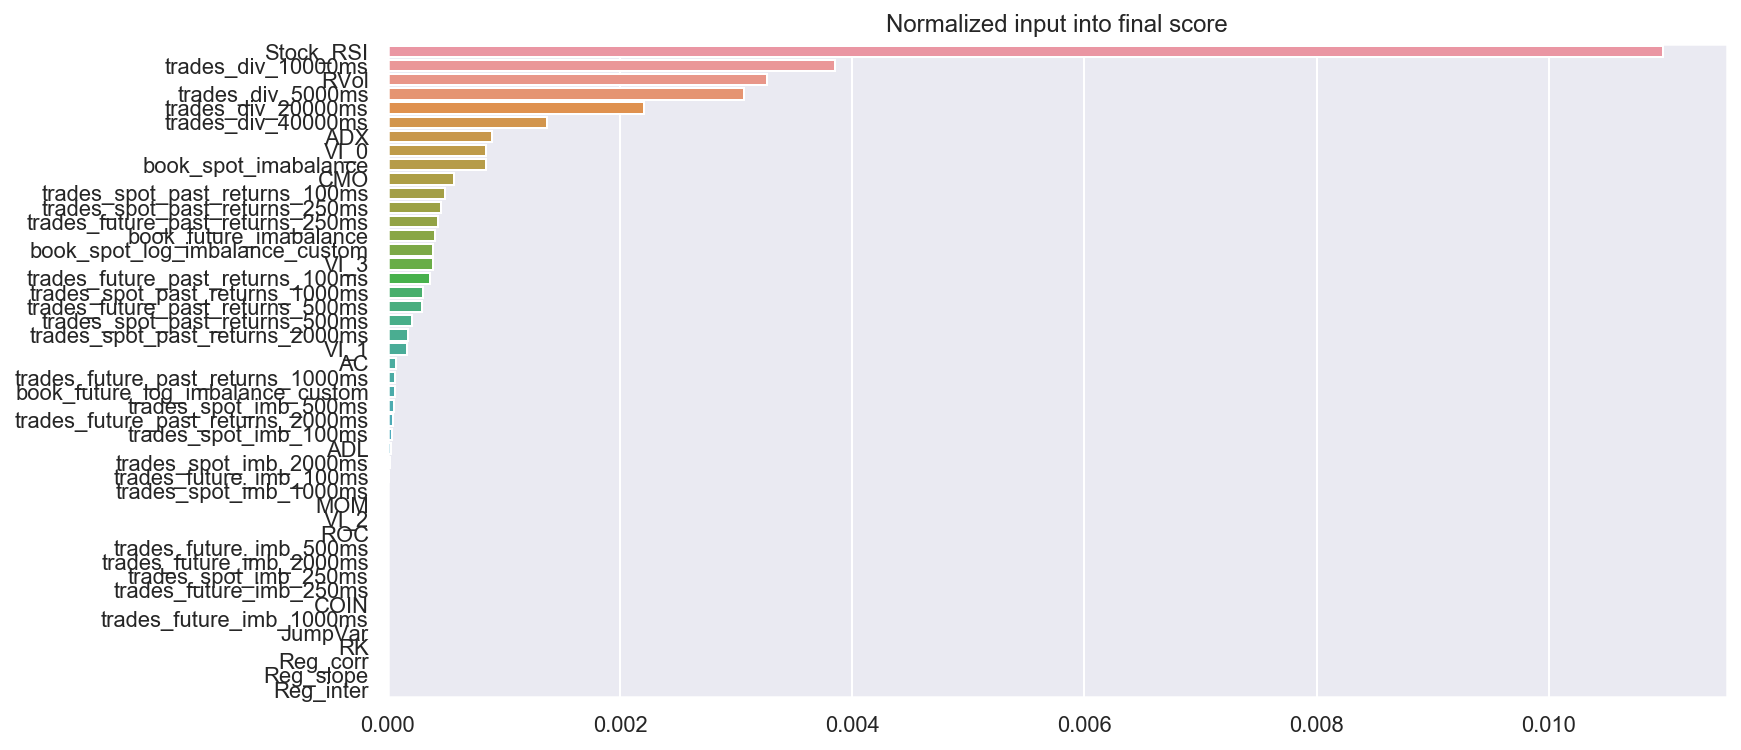

In [100]:
model_gain = model.coef_ * X_train.mean() / X_train.std()
model_gain = model_gain.abs().sort_values(ascending = False)
plt.title("Normalized input into final score")
sns.barplot(x = model_gain.values, y = model_gain.index, orient = "h")

#### LogReg Model

In [111]:
class_weight = {
    1:  1,
    -1: 1,
    0: 0.1
}
model = LogisticRegression(random_state=42, class_weight = class_weight).fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
metric(y_train[::100], model.predict(X_train[::100]))

In [ ]:
def hft_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return metric(y, y_pred)
cross_val_score(model, X_val, y_val, cv=5, scoring = hft_scorer)